In [2]:
#Imports
import numpy as np
import matplotlib.pyplot as plt 
import scipy
from astropy.table import Table
import illustris_python as il

In [6]:
"""
100-1 Loading

basePath = '/home/mattbel/Desktop/Research/BhuvSummer2020/Illustris-100-1/output'
snapshot_ind = 99
"""

"""
Loading TNG 100-3
"""
basePath = '/home/mattbel/Desktop/Research/BhuvSummer2020/Illustris-100-3/ouput'
snapshot_ind = 99 


#Header gives basic group info
header = il.groupcat.loadHeader(basePath, snapshot_ind)
#Scale Factor
scale_factor = header['Time']

#Load in the subhalo/halo tables
subhalo_grp = il.groupcat.loadSubhalos(basePath, snapshot_ind)
halo_grp = il.groupcat.loadHalos(basePath, snapshot_ind)

#Get the keys for each
subhalo_keys = (list(subhalo_grp.keys()))
halo_keys = (list(halo_grp.keys()))

#Index the table
subhalo_table = Table({'Index': [x+1 for x in range(subhalo_grp['count'])]})
#Tabulate the subhalo info
for i in range(1, len(subhalo_keys)):
    subhalo_table.add_column(subhalo_grp[str(subhalo_keys[i])], name=str(subhalo_keys[i]))

#Tabulate the halo info
for i in range(1, len(halo_keys)):
    subhalo_data = [0] * len(subhalo_table)
    for j in range(0, len(subhalo_table)):
        subhalo_data[j] = halo_grp[str(halo_keys[i])][subhalo_table['SubhaloGrNr'][j]]
    subhalo_table.add_column(subhalo_data,name=str(halo_keys[i]))

is_central = np.array([0] * len(subhalo_table), dtype=bool)
temp = halo_grp['GroupFirstSub']>-1
groupfirstsub = np.array(halo_grp['GroupFirstSub'])
is_central[groupfirstsub[temp]]=True
subhalo_table.add_column(is_central,name=str("IsCentral"))
subhalo_table.add_column(subhalo_table["SubhaloMassInHalfRadType"][:,4], name=str("StellarMassHalfRad"))
subhalo_table.add_column(subhalo_table["SubhaloMassType"][:,4], name=str("StellarMass"))


In [7]:
del subhalo_grp
del halo_grp

In [8]:
print(len(groupfirstsub))
print(len(groupfirstsub[temp]))

124773
96051


In [9]:
def cut_color_lines(table, min_gmr, max_gmr):
    mag = table['SubhaloStellarPhotometrics']
    gmr_cut_low = (mag[:,4]-mag[:,5]) > min_gmr
    gmr_cut_high = (mag[:,4]-mag[:,5])< max_gmr
    return  table[gmr_cut_low & gmr_cut_high]

def cut_color_squares(table, min_gmr, max_gmr, min_rmz, max_rmz):
    #0.46, 0.34 min_gmr and max_rmz for my original "blue"
    #0.66, 0.52 min_gmr and min_rmz for my original "red"
    mag = table['SubhaloStellarPhotometrics']
    gmr_cut_low = (mag[:,4]-mag[:,5]) > min_gmr
    gmr_cut_high = (mag[:,4]-mag[:,5])< max_gmr
    rmz_cut_low = (mag[:,5]-mag[:,7])> min_rmz
    rmz_cut_high = (mag[:,5]-mag[:,7]) < max_rmz
    return table[gmr_cut_low & gmr_cut_high & rmz_cut_low & rmz_cut_high]

def cut_mass_high(table, field, num):
    if(field == "SubhaloMassType" or field == "SubhaloMassInRadType"):
        subhalomass = np.array(np.log10(table[field][:,4]*1e10/0.704))
        mask = subhalomass > num
        return table[mask]
    else:
        subhalomass = np.array(np.log10(table[field]*1e10/0.704))
        mask = subhalomass > num
        return table[mask]

def cut_mass_low(table, field, num):
    if(field == "SubhaloMassType" or field == "SubhaloMassInRadType"):
        subhalomass = np.array(np.log10(table[field][:,4]*1e10/0.704))
        mask = subhalomass < num
        return table[mask]
    else:
        subhalomass = np.array(np.log10(table[field]*1e10/0.704))
        mask = subhalomass < num
        return table[mask]

In [33]:
print(len(subhalo_table))
subhalo_table = subhalo_table[subhalo_table['SubhaloFlag']]
subhalo_table = subhalo_table[subhalo_table['SubhaloMass']!=0]


all_galaxies = cut_mass_high(subhalo_table, "SubhaloMassType", 8)
print(len(all_galaxies))
print('Masking step 1 - remove bad subhalos - complete \n')

centrals = all_galaxies[all_galaxies['IsCentral']]
satellites = all_galaxies[np.bitwise_not(all_galaxies['IsCentral'])]
#del all_galaxies #Use for 100-1
centrals_in_cluster = centrals[centrals['GroupNsubs']>1]
field_galaxies = centrals[centrals['GroupNsubs']<=1]
print("Central galaxies: " + str(len(centrals)))
print("Satellite galaxies: " + str(len(satellites)))
print("Central galaxies that are not alone in their halo: " + str(len(centrals_in_cluster)))
print("Field Galaxies: " + str(len(field_galaxies)))
print("Masking step 2 - separate all centrals, satellites, and centrals with satellites in same halo, complete \n")


118613
16387
Masking step 1 - remove bad subhalos - complete 

Central galaxies: 10166
Satellite galaxies: 6221
Central galaxies that are not alone in their halo: 4071
Field Galaxies: 6095
Masking step 2 - separate all centrals, satellites, and centrals with satellites in same halo, complete 



<ipython-input-9-1afcef2dca95>:19: RuntimeWarning: divide by zero encountered in log10
  subhalomass = np.array(np.log10(table[field][:,4]*1e10/0.704))


In [11]:
print("Difference between average halo particle numbers and subhalo particle numbers (stellar particles)")
print(np.mean(field_galaxies['GroupLenType'][:,4])-np.mean(field_galaxies['SubhaloLenType'][:,4]))
print("Mean number of stellar halo particles")
print(np.mean(field_galaxies['GroupLenType'][:,4]))

Difference between average halo particle numbers and subhalo particle numbers (stellar particles)
0.057752255947498554
Mean number of stellar halo particles
25.592945036915506


In [12]:
#Overall bands plot
def plot_all_bands(table):
    subhalomass = np.array(np.log10(table["SubhaloMassInHalfRad"]*1e10/0.704))
    mask = subhalomass > 10.3
    st = table[mask]

    fig, ax = plt.subplots(4,2)
    fig.set_size_inches(16,20)
    plt.subplots_adjust(hspace = 0.5)
    band_names = ['U', 'B', 'V','K', 'g', 'r', 'i', 'z']
    for bands in range(8):
        mag = st['SubhaloStellarPhotometrics'][:,bands]
        ax[bands%4][bands//4].hist(mag, bins=50)
        ax[bands%4][bands//4].set_xlabel('magnitude in ' + band_names[bands] + " band", fontsize = 16 )
        ax[bands%4][bands//4].set_ylabel('count', fontsize = 16)

    plt.show()

In [13]:
def mass_vs_gmr(table, table_name, mass_type):
    #Recreating Figure 3 from https://arxiv.org/pdf/1707.03395.pdf
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]

    mass = np.array(np.log10(table[mass_type]*1e10/0.704))
    plt.ylabel("$\mathrm{g-r}$", fontsize = 16)
    plt.xlabel("Mass", fontsize = 16)
    plt.title(table_name, fontsize = 16)

    #heights, mass_bins, mag_bins = np.histogram2d(mass, mag, bins=50)
    #plt.contour(mass_bins[0:50],mag_bins[0:50], heights, colors=['red','orange','pink','green'])
    plt.hist2d(mass, mag, bins=100, cmap='viridis', cmin=0.1) #, range=[[9,12], [0,1]])
    plt.show()

In [14]:
def formation_rate_vs_gmr(table, table_name):
    table = table[table['SubhaloSFR']>0]
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
    plt.figure(figsize=(8,6))
    mass = table['SubhaloSFR']
    plt.xlabel("$\mathrm{g-r}$", fontsize = 14)
    plt.ylabel("Stellar Formation Rate: Msun/yr", fontsize = 14)
    plt.title(table_name, fontsize=16)
    
    #heights, mass_bins, mag_bins = np.histogram2d(mass, mag, bins=50)
    #plt.contour(mass_bins[0:50],mag_bins[0:50], heights, colors=['red','orange','pink','green'])
    plt.hist2d(mag, mass, bins=100, cmap='viridis', range=[[0,0.9], [0,0.8]], cmin=0.1)
    plt.colorbar()
    plt.show()

In [15]:
def metallicity_vs_gmr(table, table_name):
    table = table[table['SubhaloSFR']>0]
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
    plt.figure(figsize=(8,6))
    metallicity = table['SubhaloStarMetallicity']
    plt.xlabel("$\mathrm{g-r}$", fontsize = 14)
    plt.ylabel("Mass-weighted average metallicity", fontsize = 14)
    plt.title(table_name, fontsize=16)
    
    #heights, mass_bins, mag_bins = np.histogram2d(mass, mag, bins=50)
    #plt.contour(mass_bins[0:50],mag_bins[0:50], heights, colors=['red','orange','pink','green'])
    plt.hist2d(mag, metallicity, bins=100, cmap='viridis', range=[[0,0.9], [0,0.08]], cmin=0.1)
    plt.colorbar()
    plt.show()

In [16]:
def formation_rate_vs_mass(table, table_name, mass_type):
    #Recreating Figure 3 from https://arxiv.org/pdf/1707.03395.pdf
    table = table[table['SubhaloSFR']>0]
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
    #table = table[mag<0.55] #mag cut 
    mass = np.array(np.log10(table[mass_type]*1e10/0.704))
    plt.figure(figsize=(8,6))
    sfr = table['SubhaloSFR']
    plt.xlabel("Mass", fontsize = 14)
    plt.ylabel("Stellar Formation Rate: Msun/yr", fontsize = 14)
    plt.title(table_name, fontsize=16)
    
    #heights, mass_bins, mag_bins = np.histogram2d(mass, mag, bins=50)
    #plt.contour(mass_bins[0:50],mag_bins[0:50], heights, colors=['red','orange','pink','green'])
    plt.hist2d(mass, sfr, bins=100, cmap='viridis', cmin=0.1, range=[[8,12.5],[0,0.4]])
    plt.colorbar()
    plt.show()

In [17]:
def hydrogen_rate_vs_gmr(table, table_name):
    #Recreating Figure 3 from https://arxiv.org/pdf/1707.03395.pdf
    table = table[table['SubhaloStarMetalFractions'][:,0]>0]
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
    plt.figure(figsize=(8,6))
    plt.xlabel("$\mathrm{g-r}$", fontsize = 14)
    plt.ylabel("Hydrogen Abundance", fontsize = 14)
    plt.title(table_name, fontsize=16)
    
    #heights, mass_bins, mag_bins = np.histogram2d(mass, mag, bins=50)
    #plt.contour(mass_bins[0:50],mag_bins[0:50], heights, colors=['red','orange','pink','green'])
    plt.hist2d(mag, table['SubhaloStarMetalFractions'][:,0], bins=100, cmap='viridis', cmin=0.1) #, range=[[0,0.9], [0.6,0.9]])
    plt.colorbar()
    plt.show()

In [18]:
def helium_rate_vs_gmr(table, table_name):
    #Recreating Figure 3 from https://arxiv.org/pdf/1707.03395.pdf
    table = table[table['SubhaloStarMetalFractions'][:,1]>0]
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
    plt.figure(figsize=(8,6))
    plt.xlabel("$\mathrm{g-r}$", fontsize = 14)
    plt.ylabel("Helium Abundance", fontsize = 14)
    plt.title(table_name, fontsize=16)
    
    #heights, mass_bins, mag_bins = np.histogram2d(mass, mag, bins=50)
    #plt.contour(mass_bins[0:50],mag_bins[0:50], heights, colors=['red','orange','pink','green']
    plt.hist2d(mag, table['SubhaloStarMetalFractions'][:,1], bins=100, cmap='viridis', cmin=0.1) #, range=[[0,0.9], [0.6,0.9]])
    plt.colorbar()
    plt.show()

In [19]:
def element_rate_vs_mass(table, table_name, mass_type):
    elements = ['H', 'He', 'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'Fe']
    fig, ax = plt.subplots(3,3)
    fig.set_size_inches(16,16)
    for i in range (0, len(elements)):
        #mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
        #table = table[mag>0.55] 
        #Recreating Figure 3 from https://arxiv.org/pdf/1707.03395.pdf
        #table = table[table['SubhaloStarMetalFractions']>0]
        
        mass = np.array(np.log10(table[mass_type]*1e10/0.704))
        ax[i//3][i%3].set_xlabel("Mass: " + str(mass_type), fontsize = 11)
        ax[i//3][i%3].set_ylabel(elements[i] + " Abundance", fontsize = 11)
        ax[i//3][i%3].set_title(elements[i] + " in " + table_name, fontsize=12)

        #heights, mass_bins, mag_bins = np.histogram2d(mass, mag, bins=50)
        #plt.contour(mass_bins[0:50],mag_bins[0:50], heights, colors=['red','orange','pink','green']
        ax[i//3][i%3].hist2d(mass, table['SubhaloStarMetalFractions'][:,i], bins=100, cmap='viridis', cmin=0.1)


In [20]:
def element_rate_vs_gmr(table, table_name):
    elements = ['H', 'He', 'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'Fe']
    for i in range (0, len(elements)):
        #Recreating Figure 3 from https://arxiv.org/pdf/1707.03395.pdf
        #table = table[table['SubhaloStarMetalFractions']>0]
        mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]
        plt.figure(figsize=(6,4))
        plt.xlabel("$\mathrm{g-r}$", fontsize = 11)
        plt.ylabel(elements[i] + " Abundance", fontsize = 11)
        plt.title(elements[i] + " in " + table_name, fontsize=12)

        #heights, mass_bins, mag_bins = np.histogram2d(mass, mag, bins=50)
        #plt.contour(mass_bins[0:50],mag_bins[0:50], heights, colors=['red','orange','pink','green']
        plt.hist2d(mag, table['SubhaloStarMetalFractions'][:,i], bins=100, cmap='viridis', cmin=0.1) 
        plt.colorbar()
        plt.show()


In [21]:
def gmr_mass_bins_hist(table, table_name, mass_type):
    bins = [9.0,9.5,10.0,10.5,11.0,11.5,12.0]
    fig, ax = plt.subplots(2,3)
    fig.set_size_inches(18,11)
    for i in range(0,6):
        s1 = cut_mass_high(table, mass_type, bins[i])
        s2 = cut_mass_low(table, mass_type, bins[i+1])
        mask2 = np.array(np.log10(s1[mass_type]*1e10/0.704)) < bins[i+1]
        s2 = s1[mask2]

        print(min(np.array(np.log10(s2[mass_type]*1e10/0.704))))
        print(max(np.array(np.log10(s2[mass_type]*1e10/0.704))))
        
        mag = s2['SubhaloStellarPhotometrics'][:,4] - s2['SubhaloStellarPhotometrics'][:,5]
        ax[i//3][i%3].hist(mag, bins=50) #, density=True)
        ax[i//3][i%3].set_title("Mass bin: "+str(bins[i])+"-"+str(bins[i+1]) + " for table: " + table_name)
        ax[i//3][i%3].set_xlabel('magnitude in g-r band', fontsize = 16 )
        ax[i//3][i%3].set_ylabel('count', fontsize = 16)

In [22]:
def color_color(mag, r1, r2, table_name):
    g_minus_r = mag[:,4]-mag[:,5]
    r_minus_z = mag[:,5]-mag[:,7]
    plt.figure(figsize=(10,8))
    #heights, rmz,gmr = np.histogram2d(r_minus_z,g_minus_r,bins=150)
    plt.hist2d(g_minus_r,r_minus_z, bins = 150, cmap='viridis', range=[[r1, 1], [r2, 1]], cmin = 0.1)
    plt.xlabel("$\mathrm{g-r}$", fontsize = 20)
    plt.ylabel("$\mathrm{r-z}$", fontsize = 20)
    plt.title("Color-Color plane plot for " + table_name, fontsize = 20)
    plt.colorbar()
    plt.grid(b=True, which='both', axis='both')
    #print(len(g_minus_r))
    #print(str(len(g_minus_r[g_minus_r>0.5])) + "\n")
    #levels = np.linspace(0, 40,num=4)
    #plt.contour(gmr[0:150],rmz[0:150], heights, levels=levels, 
                #extent=[0,0,0.8,0.7], colors=['red','orange','pink','green'])

In [23]:
def color_density(mag, band1, band2, band3, title):
    band_names = ['U', 'B', 'V','K', 'g', 'r', 'i', 'z']
    r = mag[:,band1]
    r_minus_z = mag[:,band2]-mag[:,band3]
    plt.figure(figsize=(8,6))
    plt.hist2d(r, r_minus_z, bins = 80, cmap='viridis', cmin=0.1)#, range=[[0, 0.7], [0, 0.8]])
    plt.ylabel(band_names[band2]+"-"+band_names[band3], fontsize = 20)
    plt.xlabel(band_names[band1], fontsize = 20)
    plt.title(title, fontsize = 20)
    plt.colorbar()

In [24]:
def galaxy_dist_vs_mass(table, table_name, color, mass_type):
    
    boxsize = header['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)#*conv_fac
    dev = table['SubhaloCM']-table['GroupCM']
 
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q
    r_subhalo = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h
    
    mass = np.array(np.log10(table[mass_type]*1e10/0.704))
    plt.figure(figsize=(8,6))
    plt.hist2d(mass, r_subhalo, bins=120, cmap='viridis', cmin=0.1, range=[[8,12.5],[0,4]])
    plt.xlabel(mass_type)
    plt.ylabel("Distance in Mpc/h")
    plt.title("Distance of "  + color + " " + table_name + " from Halo Center vs. Mass.")
    plt.colorbar()
    plt.show()

In [25]:
def rotation_curve_vs_mass(table, table_name, color, mass_type):
    plt.figure(figsize=(8,6))
    mass = (np.log10(table[mass_type]*1e10/0.704))
    plt.hist2d(mass,table['SubhaloVmax'], bins=120, cmap='viridis', cmin=0.1, range=[[8,12.5],[0,800]])
    plt.title("Mass vs. max of rotation curve for " + color + " " + table_name)
    plt.ylabel("Max of spherically-averaged rotation curve. (km/s)", fontsize=14)
    plt.xlabel("Mass")
    plt.show()

In [26]:
def peculiar_velocity_vs_mass(table, table_name, color, mass_type):
    v=table['SubhaloVel']-table['GroupVel']/scale_factor
    velocity = np.sqrt((v[:,0])**2 + (v[:,1])**2 +(v[:,2])**2)
    print(np.mean(velocity))
    
    mass = np.array(np.log10(table[mass_type]*1e10/0.704))
    plt.figure(figsize=(8,6))
    plt.hist2d(mass,velocity, bins=120, cmap='viridis', cmin=0.1, range=[[8,12.5],[0,3000]])
    plt.title("Mass vs. Peculiar velocity " + color + " " + table_name , fontsize=14)
    plt.ylabel("Peculiar velocity of the subhalo. (km/s)", fontsize=14)
    plt.xlabel(mass_type, fontsize=14)
    plt.colorbar()
    plt.show()


In [27]:
def vsq_vs_r(table, table_name, color, mass_type):
    
    v=table['SubhaloVel']-table['GroupVel']/scale_factor
    velocity_sq = (v[:,0])**2 + (v[:,1])**2 +(v[:,2])**2

    
    boxsize = header['BoxSize'] #kpc/h
    box_bounds = boxsize*np.ones(3)#*conv_fac
    dev = table['SubhaloCM']-table['GroupCM']
 
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q
    r_subhalo = np.linalg.norm(dev, axis=1)*.001*scale_factor #Mpc/h
    
    plt.figure(figsize=(8,6))
    plt.hist2d(r_subhalo,velocity_sq, bins=120, cmap='viridis', cmin=0.1)
    plt.title("Radius vs. velocity^2 " + color + " " + table_name , fontsize=14)
    plt.ylabel("Peculiar velocity of the subhalo squared. (km/s)", fontsize=14)
    plt.xlabel("Radius", fontsize=14)
    plt.colorbar()
    plt.show()


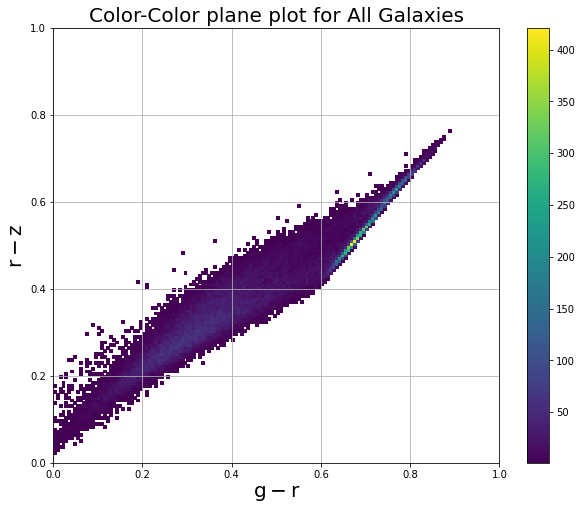

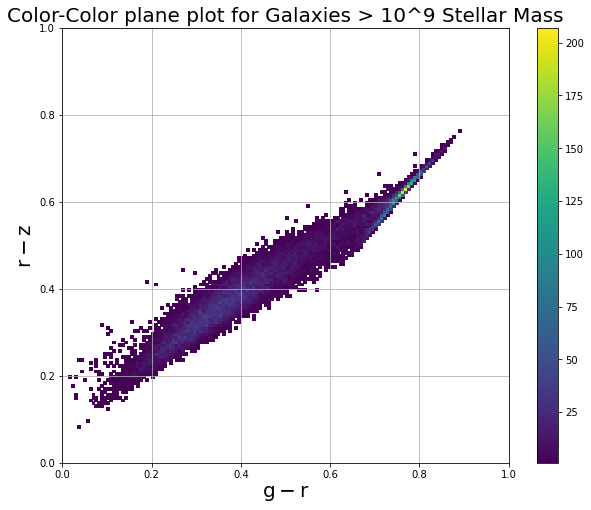

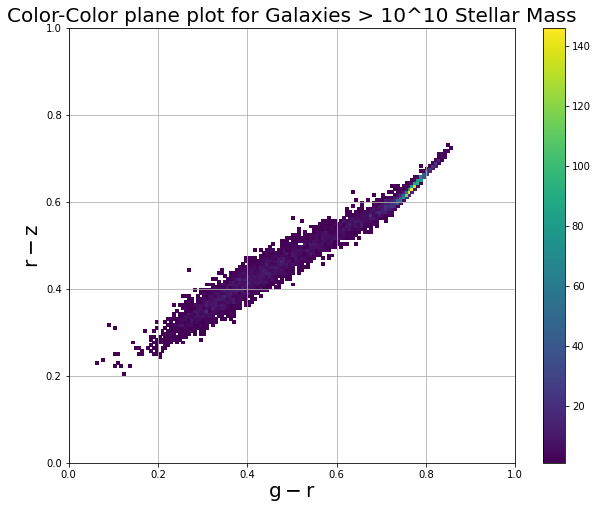

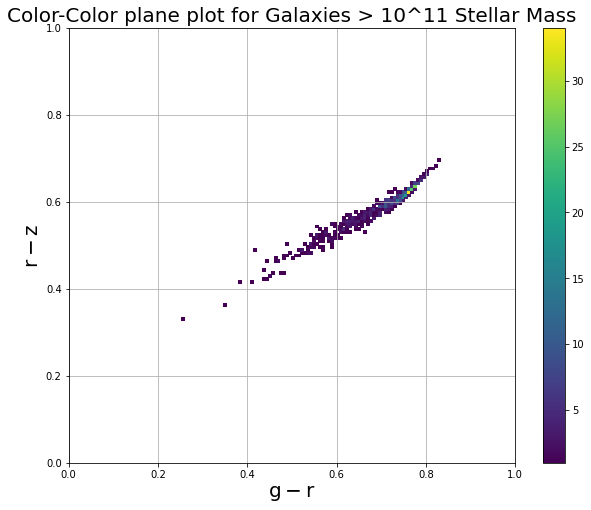

In [27]:
#plot_all_bands(all_galaxies)

color_color(all_galaxies['SubhaloStellarPhotometrics'], 0.0, 0.0, "All Galaxies")
testing = cut_mass_high(all_galaxies, "StellarMass", 9)
color_color(testing['SubhaloStellarPhotometrics'], 0.0, 0.0, "Galaxies > 10^9 Stellar Mass")
testing = cut_mass_high(all_galaxies, "StellarMass", 10)
color_color(testing['SubhaloStellarPhotometrics'], 0.0, 0.0, "Galaxies > 10^10 Stellar Mass")
testing = cut_mass_high(all_galaxies, "StellarMass",11)
color_color(testing['SubhaloStellarPhotometrics'], 0.0, 0.0, "Galaxies > 10^11 Stellar Mass")


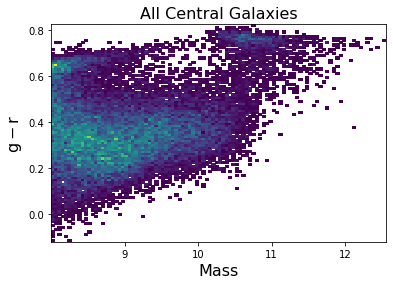

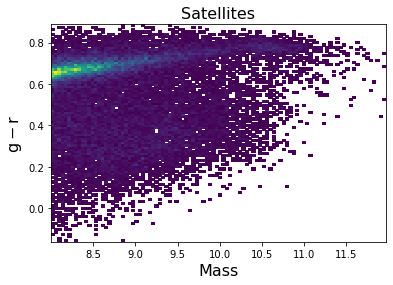

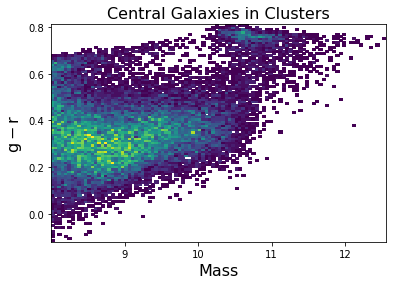

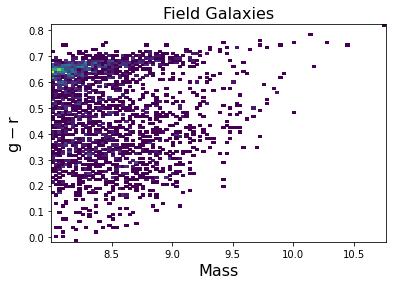

In [30]:
#mass_vs_gmr(all_galaxies, "All Galaxies", "StellarMass")
mass_vs_gmr(centrals, "All Central Galaxies", "StellarMass")
mass_vs_gmr(satellites, "Satellites", "StellarMass")
mass_vs_gmr(centrals_in_cluster, "Central Galaxies in Clusters", "StellarMass")
mass_vs_gmr(field_galaxies, "Field Galaxies", "StellarMass")

In [31]:
"""
Define color splits as per Tara's slide 24
"""

centrals_red = cut_mass_high(cut_color_lines(centrals, 0.6, 1000), "StellarMass" ,10.2)
centrals_green = cut_mass_low(cut_color_lines(centrals, 0.6, 1000), "StellarMass" ,10.2)
centrals_blue = cut_color_lines(centrals, 0, 0.5)

satellites_red = cut_mass_high(cut_color_lines(satellites, 0.6, 1000), "StellarMass" ,10.2)
satellites_green = cut_mass_low(cut_color_lines(satellites, 0.6, 1000), "StellarMass" ,10.2)
satellites_blue = cut_color_lines(satellites, 0, 0.5)

centrals_in_cluster_red = cut_mass_high(cut_color_lines(centrals_in_cluster, 0.6, 1000), "StellarMass" ,10.2)
centrals_in_cluster_green = cut_mass_low(cut_color_lines(centrals_in_cluster, 0.6, 1000), "StellarMass" ,10.2)
centrals_in_cluster_blue = cut_color_lines(centrals_in_cluster, 0, 0.5)

field_galaxies_red = cut_mass_high(cut_color_lines(field_galaxies, 0.6, 1000), "StellarMass" ,10.2)
field_galaxies_green = cut_mass_low(cut_color_lines(field_galaxies, 0.6, 1000), "StellarMass" ,10.2)
field_galaxies_blue = cut_color_lines(field_galaxies, 0, 0.5)


print("Central galaxies red: " + str(len(centrals_red)))
print("Central galaxies green: " + str(len(centrals_green)))
print("Central galaxies blue: " + str(len(centrals_blue)))

print("Satellite galaxies red: " + str(len(satellites_red)))
print("Satellite galaxies green: " + str(len(satellites_green)))
print("Satellite galaxies blue: " + str(len(satellites_blue)))

print("Central galaxies that are not alone in their halo red: " + str(len(centrals_in_cluster_red)))
print("Central galaxies that are not alone in their halo green: " + str(len(centrals_in_cluster_green)))
print("Central galaxies that are not alone in their halo blue: " + str(len(centrals_in_cluster_blue)))

print("Field Galaxies red: " + str(len(field_galaxies_red)))
print("Field Galaxies green: " + str(len(field_galaxies_green)))
print("Field Galaxies blue: " + str(len(field_galaxies_blue)))

print("Masking step 3 - color bimodality for each type of galaxy, complete \n")


Central galaxies red: 1474
Central galaxies green: 1930
Central galaxies blue: 21777
Satellite galaxies red: 1191
Satellite galaxies green: 11374
Satellite galaxies blue: 7302
Central galaxies that are not alone in their halo red: 1471
Central galaxies that are not alone in their halo green: 1031
Central galaxies that are not alone in their halo blue: 20733
Field Galaxies red: 3
Field Galaxies green: 899
Field Galaxies blue: 1044
Masking step 3 - color bimodality for each type of galaxy, complete 



9.000071
9.499897
9.500013
9.999998
10.000164
10.499819
10.5000725
10.999929
11.000638
11.496601
11.501167
11.9817295
9.000121
9.499807
9.500092
9.999772
10.000164
10.499819
10.500429
10.999506
11.001968
11.496601
11.505059
11.971549
9.000071
9.499897
9.500013
9.999998
10.000187
10.499637
10.5000725
10.999929
11.000638
11.49644
11.501167
11.9817295


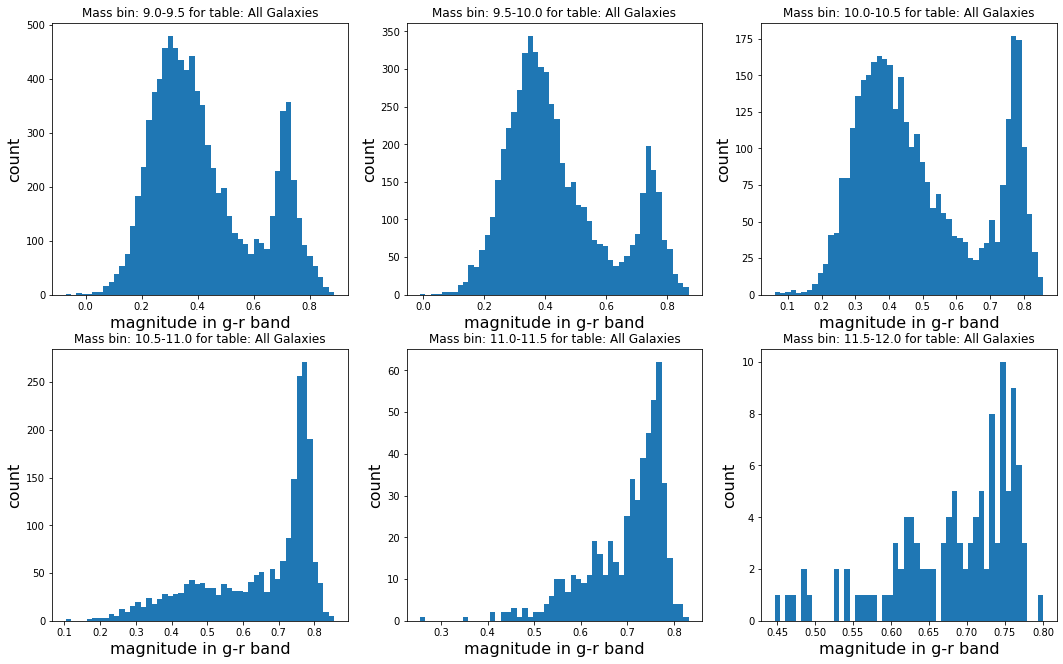

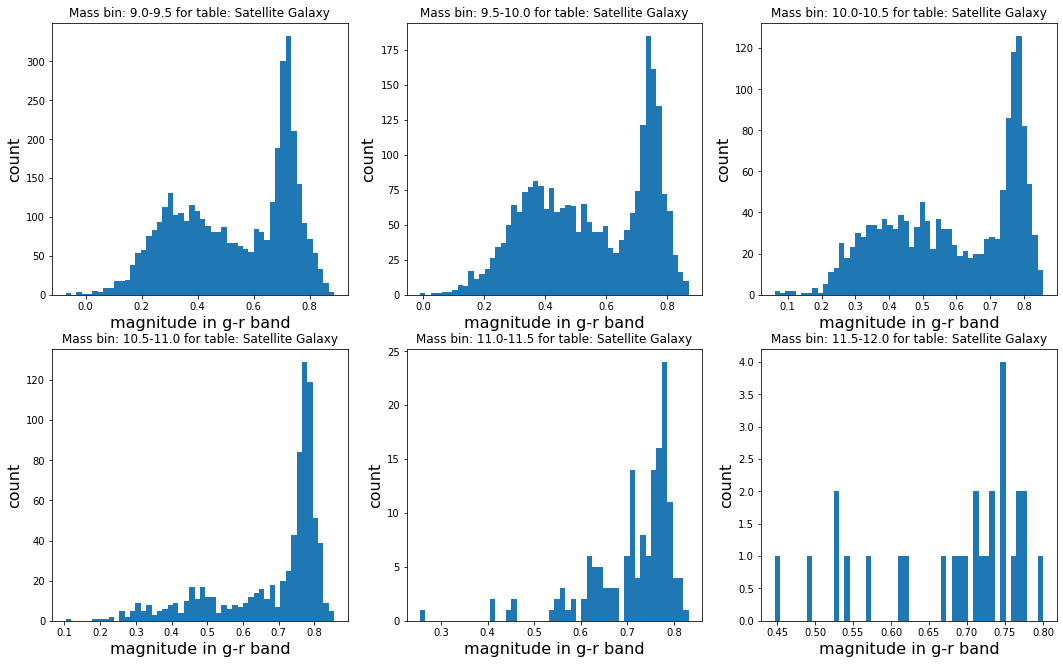

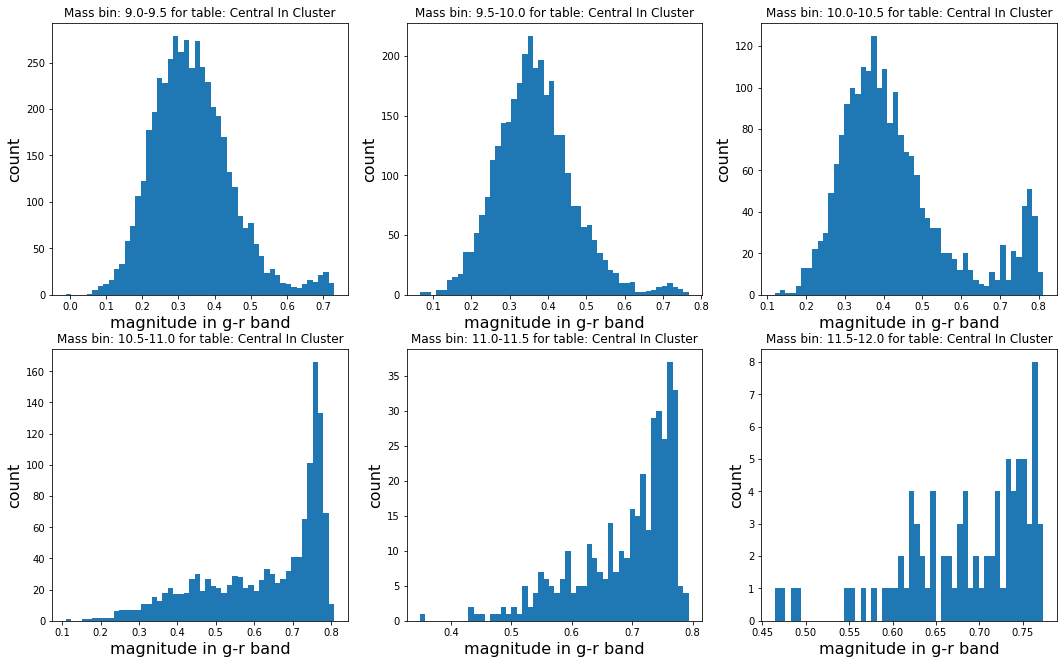

In [32]:
gmr_mass_bins_hist(all_galaxies, "All Galaxies" ,"StellarMass")
gmr_mass_bins_hist(satellites, "Satellite Galaxy" ,"StellarMass")
gmr_mass_bins_hist(centrals_in_cluster, "Central In Cluster" ,"StellarMass")

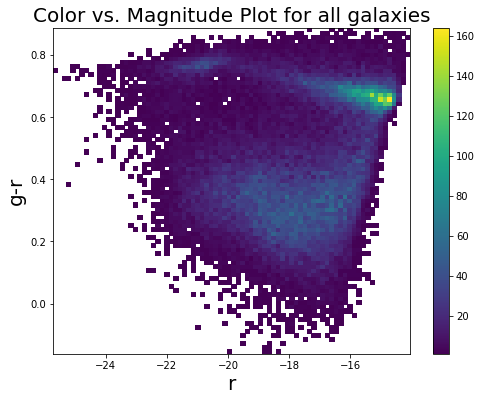

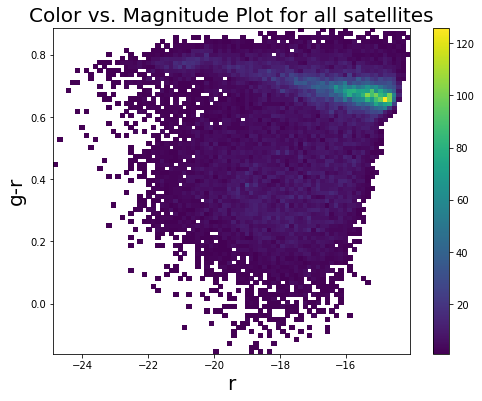

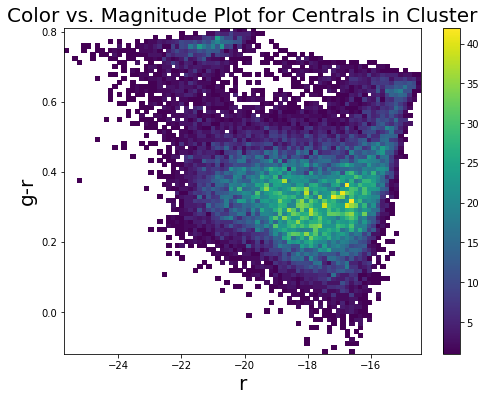

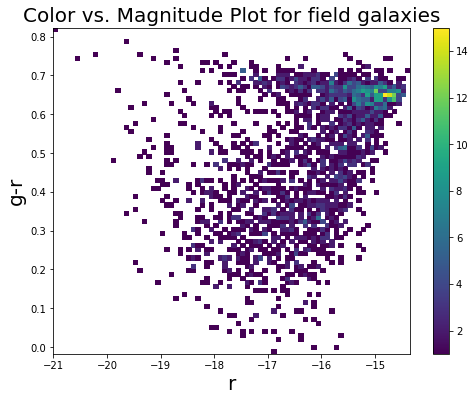

In [34]:
#color_color(all_galaxies['SubhaloStellarPhotometrics'], 0.0, 0.0, "All Galaxies")
color_density(all_galaxies['SubhaloStellarPhotometrics'], 5, 4, 5, "Color vs. Magnitude Plot for all galaxies")
#color_color(satellites['SubhaloStellarPhotometrics'], 0.0, 0.0, "All satellites")
color_density(satellites['SubhaloStellarPhotometrics'], 5, 4, 5, "Color vs. Magnitude Plot for all satellites")
#color_color(centrals_in_cluster['SubhaloStellarPhotometrics'], 0.0, 0.0, "Centrals In Cluster")
color_density(centrals_in_cluster['SubhaloStellarPhotometrics'], 5, 4, 5, 
              "Color vs. Magnitude Plot for Centrals in Cluster")

#color_color(field_galaxies['SubhaloStellarPhotometrics'], 0.0, 0.0, "Field Galaxies")

color_density(field_galaxies['SubhaloStellarPhotometrics'], 5, 4, 5, "Color vs. Magnitude Plot for field galaxies")

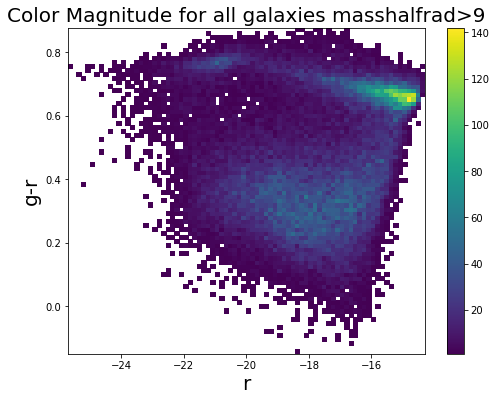

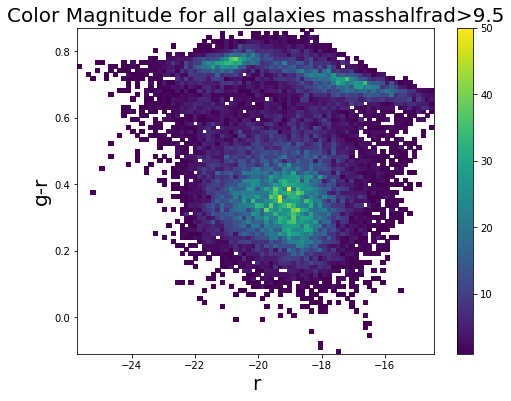

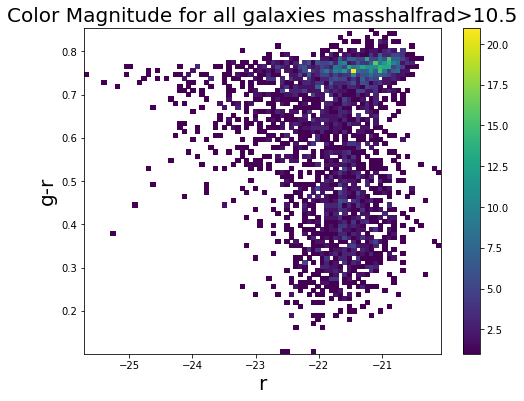

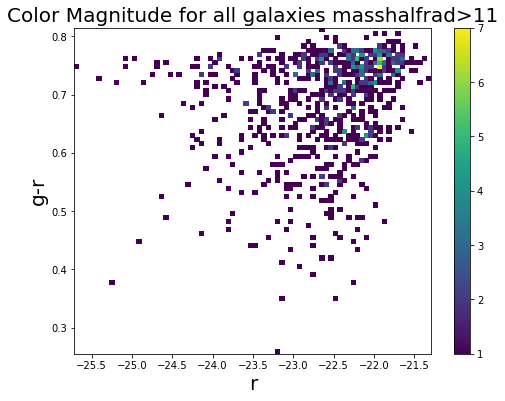

In [35]:
testing = cut_mass_high(all_galaxies, "SubhaloMassInHalfRad", 9)
color_density(testing['SubhaloStellarPhotometrics'], 5,4, 5, "Color Magnitude for all galaxies masshalfrad>9")
testing = cut_mass_high(all_galaxies, "SubhaloMassInHalfRad", 9.5)
color_density(testing['SubhaloStellarPhotometrics'], 5,4, 5, "Color Magnitude for all galaxies masshalfrad>9.5")
# I-band magnitude 19.9
testing = cut_mass_high(all_galaxies, "SubhaloMassInHalfRad", 10.5)
color_density(testing['SubhaloStellarPhotometrics'], 5,4, 5, "Color Magnitude for all galaxies masshalfrad>10.5")
testing = cut_mass_high(all_galaxies, "SubhaloMassInHalfRad", 11)
color_density(testing['SubhaloStellarPhotometrics'], 5,4, 5, "Color Magnitude for all galaxies masshalfrad>11")

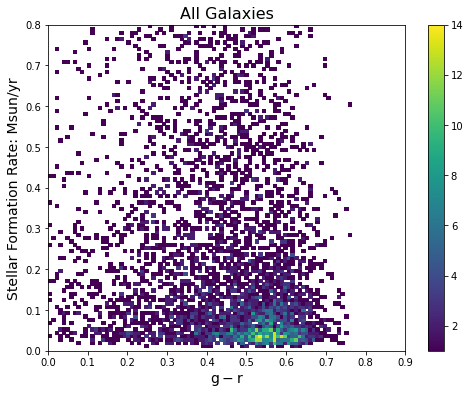

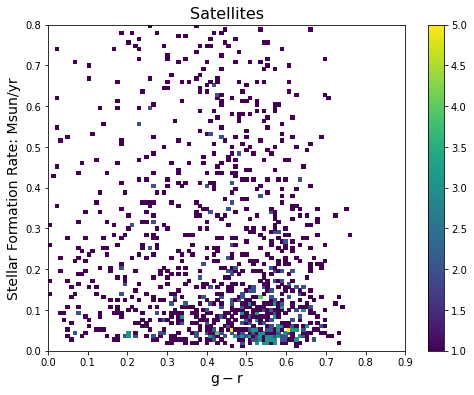

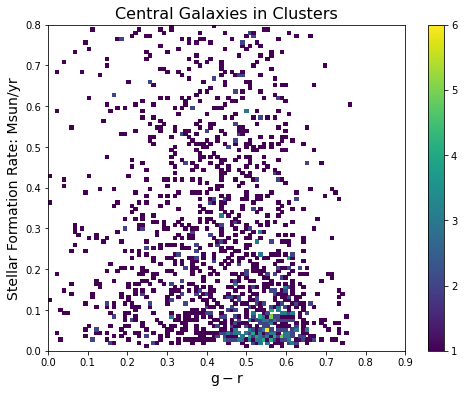

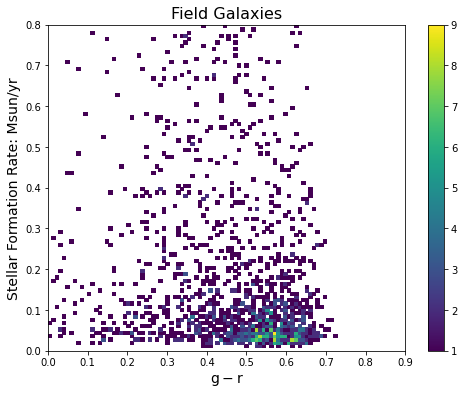

In [29]:
#Color-evolution
formation_rate_vs_gmr(all_galaxies, "All Galaxies")
formation_rate_vs_gmr(satellites, "Satellites")
formation_rate_vs_gmr(centrals_in_cluster, "Central Galaxies in Clusters")
formation_rate_vs_gmr(field_galaxies, "Field Galaxies")

#Color-magnitude


In [ ]:
testing = cut_mass_high(centrals_in_cluster, "SubhaloMassInHalfRad", 9.4)
formation_rate_vs_gmr(testing, "Central Galaxies in Clusters, mass>10^9.4")


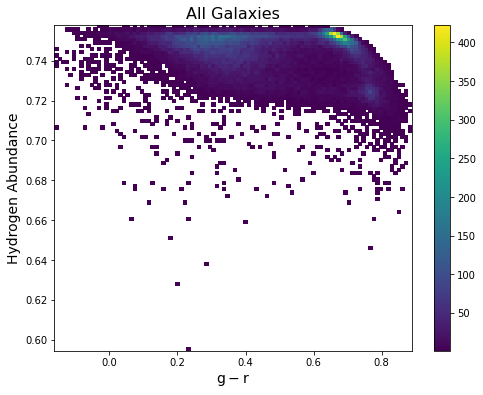

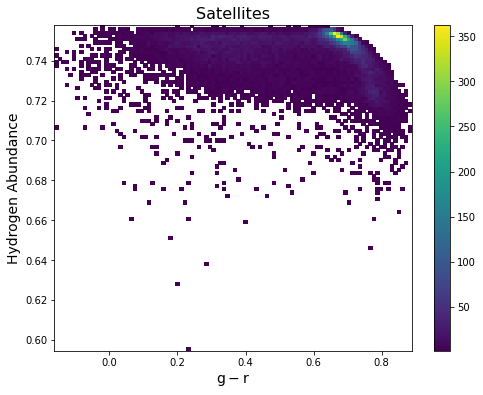

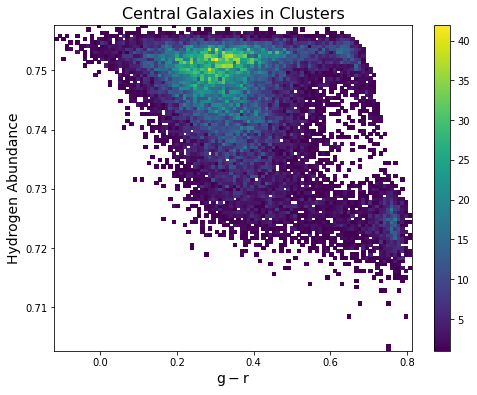

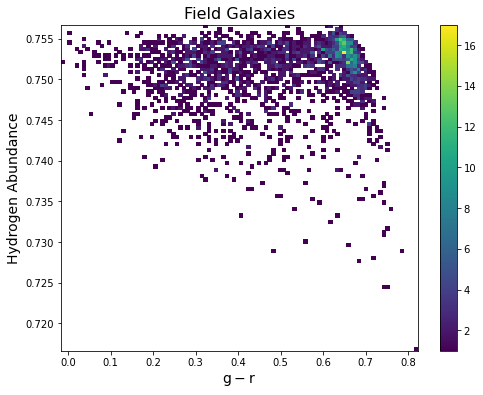

In [37]:
hydrogen_rate_vs_gmr(all_galaxies, "All Galaxies")
hydrogen_rate_vs_gmr(satellites, "Satellites")
hydrogen_rate_vs_gmr(centrals_in_cluster, "Central Galaxies in Clusters")
hydrogen_rate_vs_gmr(field_galaxies, "Field Galaxies")

In [ ]:
testing = cut_mass_high(centrals_in_cluster, "SubhaloMassInHalfRad", 10)
hydrogen_rate_vs_gmr(testing, "Central Galaxies in Clusters, mass>10^10")


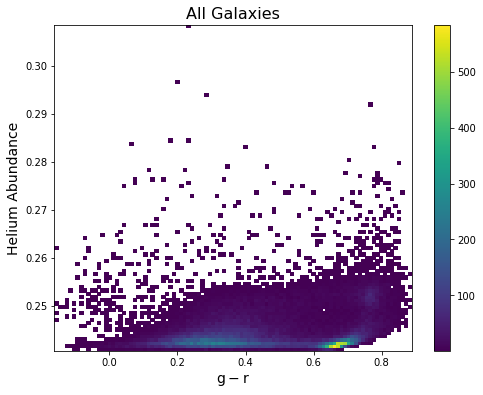

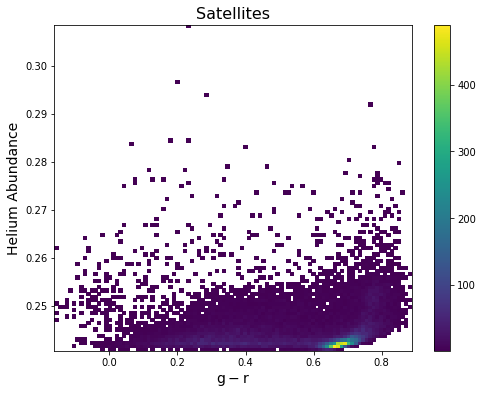

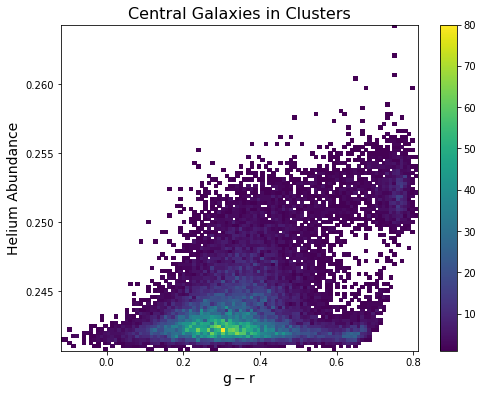

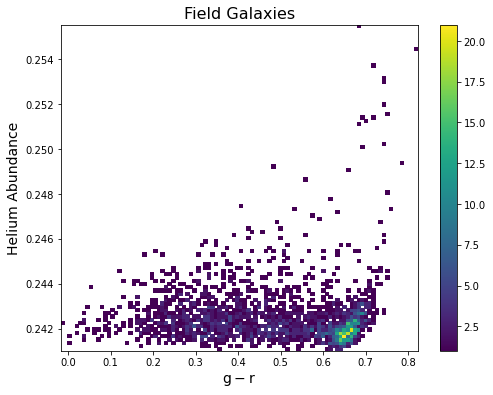

In [49]:
helium_rate_vs_gmr(all_galaxies, "All Galaxies")
helium_rate_vs_gmr(satellites, "Satellites")
helium_rate_vs_gmr(centrals_in_cluster, "Central Galaxies in Clusters")
helium_rate_vs_gmr(field_galaxies, "Field Galaxies")

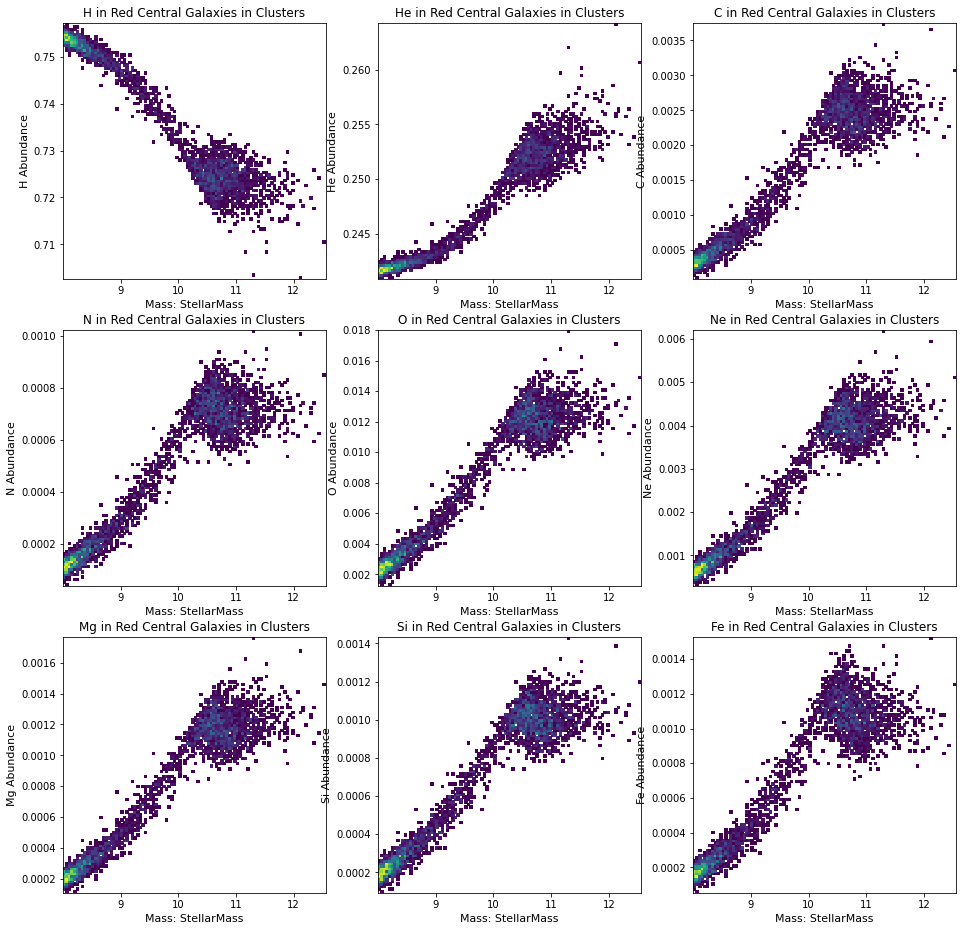

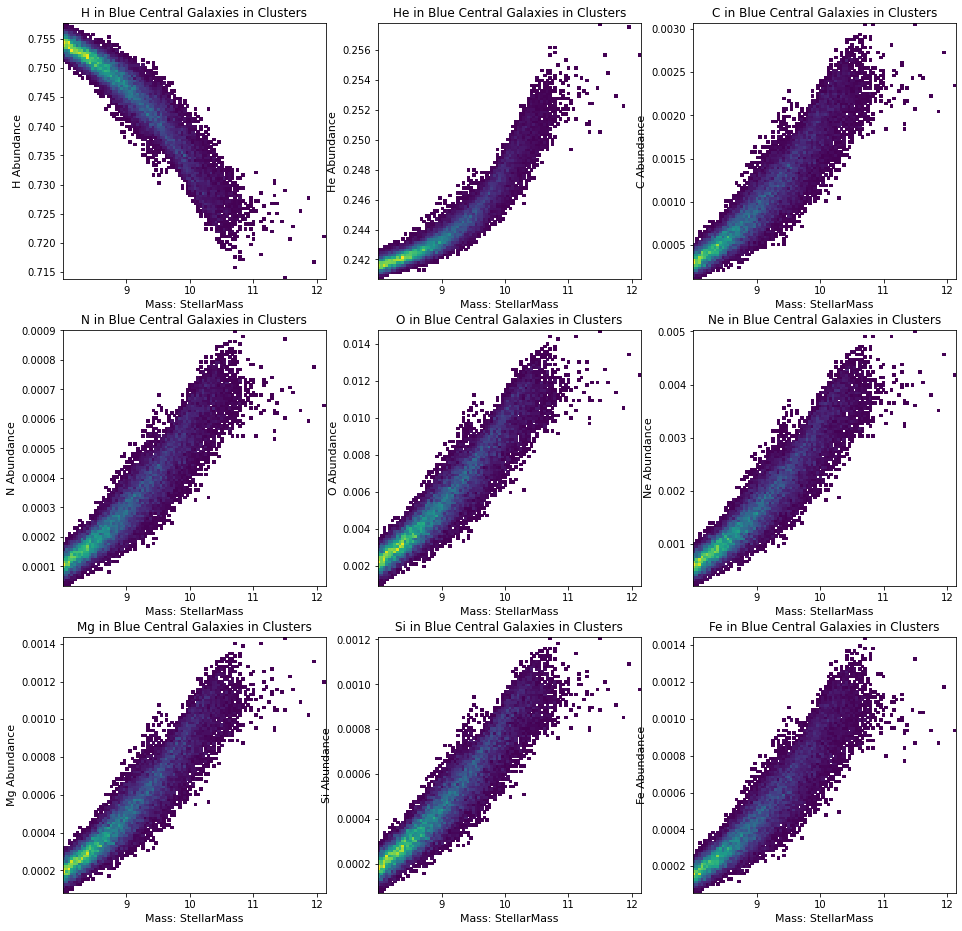

In [87]:
#element_rate_vs_gmr(centrals_in_cluster, "Central Galaxies in Clusters")
#element_rate_vs_gmr(field_galaxies, "satellites")
mag = centrals_in_cluster['SubhaloStellarPhotometrics'][:,4] - centrals_in_cluster['SubhaloStellarPhotometrics'][:,5]
to_send = centrals_in_cluster[mag>0.55] 
element_rate_vs_mass(to_send, "Red Central Galaxies in Clusters", "StellarMass")

to_send = centrals_in_cluster[mag<0.55] 
element_rate_vs_mass(to_send, "Blue Central Galaxies in Clusters", "StellarMass")

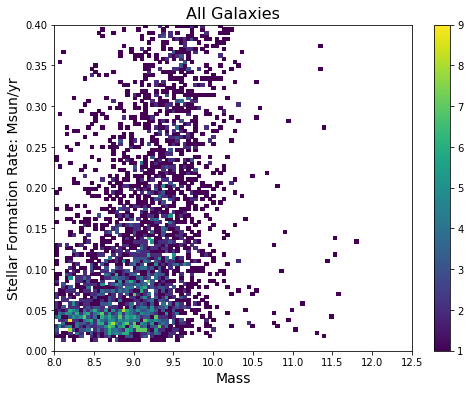

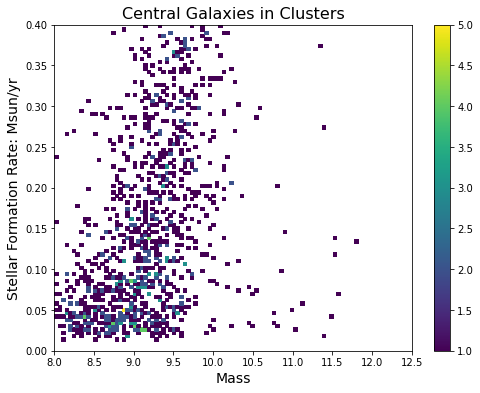

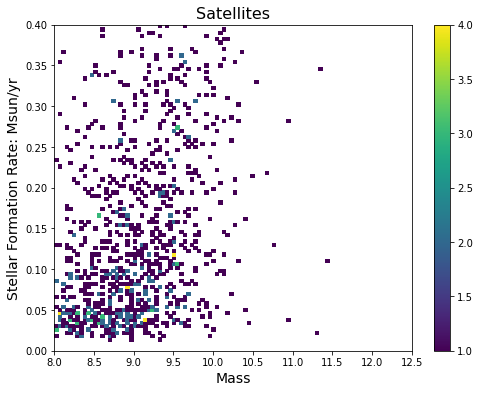

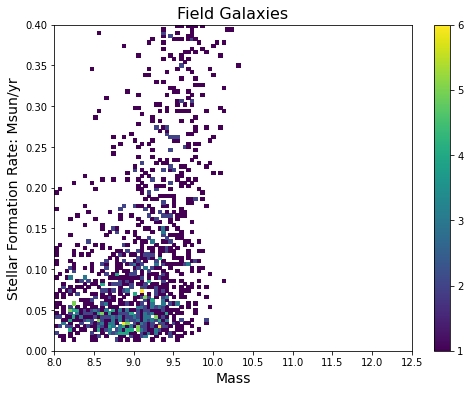

In [28]:
formation_rate_vs_mass(all_galaxies, "All Galaxies" ,"StellarMass")
formation_rate_vs_mass(centrals_in_cluster, "Central Galaxies in Clusters" ,"StellarMass")
formation_rate_vs_mass(satellites, "Satellites" ,"StellarMass")
formation_rate_vs_mass(field_galaxies, "Field Galaxies" ,"StellarMass")


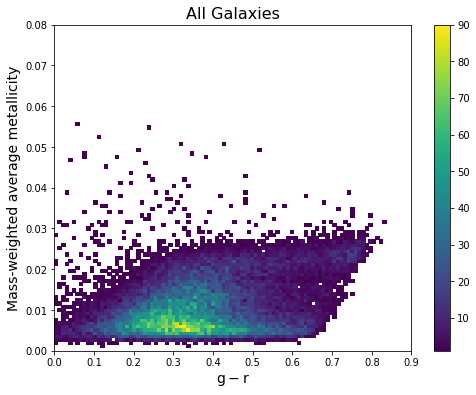

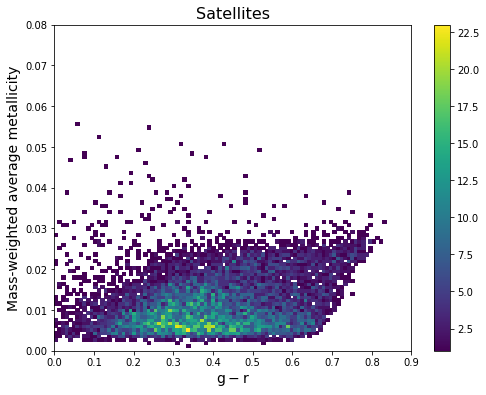

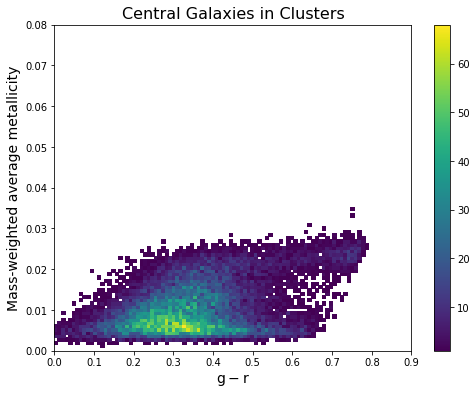

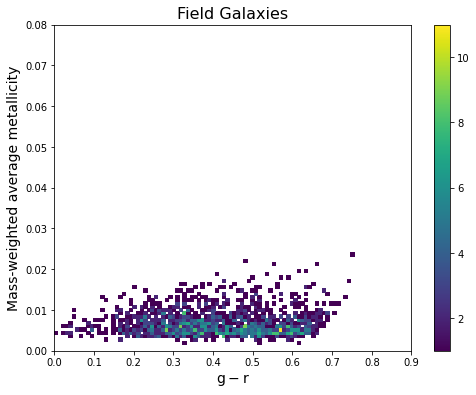

In [69]:
metallicity_vs_gmr(all_galaxies, "All Galaxies")
metallicity_vs_gmr(satellites, "Satellites")
metallicity_vs_gmr(centrals_in_cluster, "Central Galaxies in Clusters")
metallicity_vs_gmr(field_galaxies, "Field Galaxies")

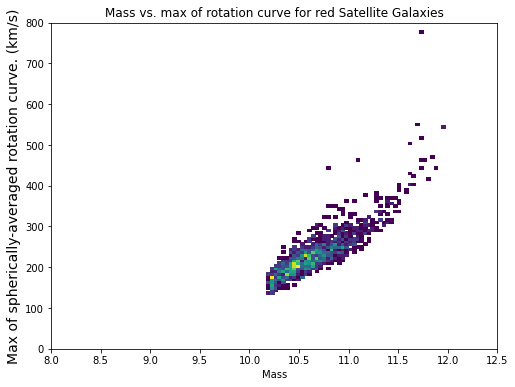

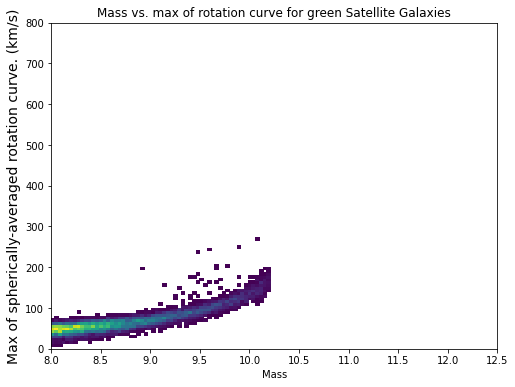

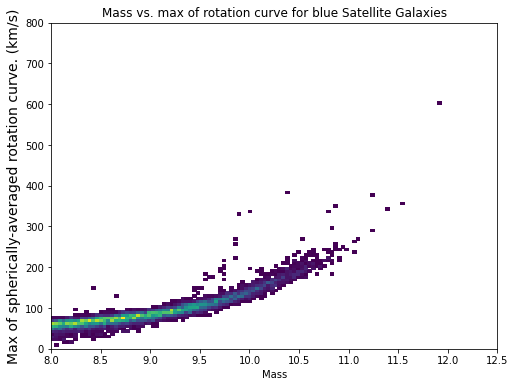

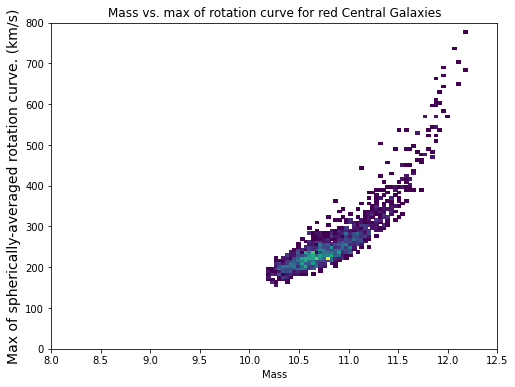

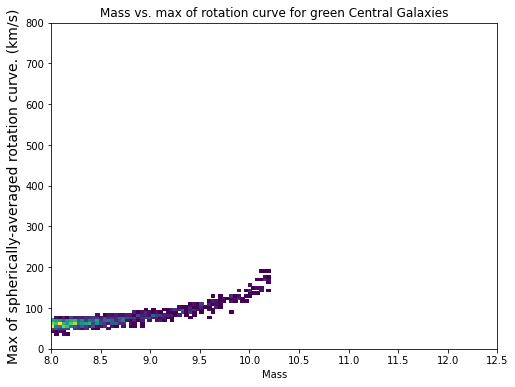

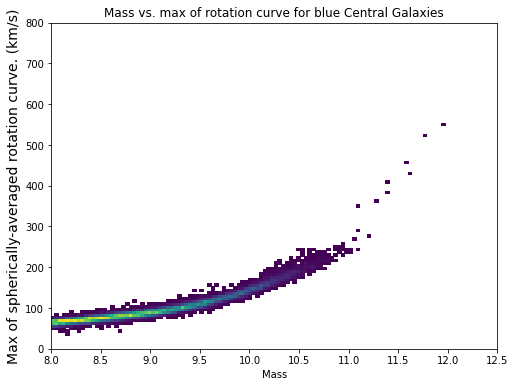

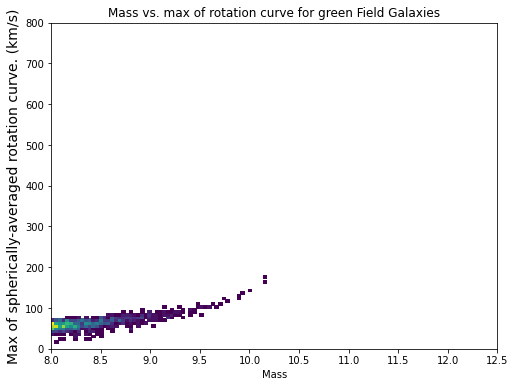

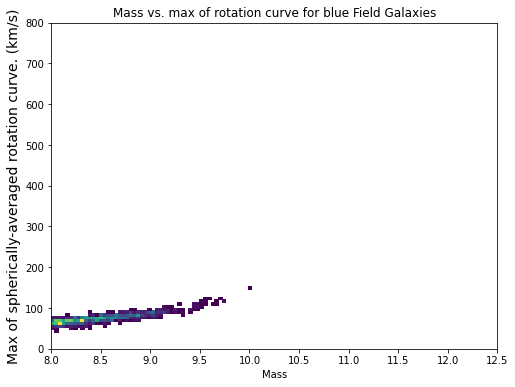

In [127]:

rotation_curve_vs_mass(satellites_red, "Satellite Galaxies", "red", "StellarMass")
rotation_curve_vs_mass(satellites_green, "Satellite Galaxies", "green", "StellarMass")
rotation_curve_vs_mass(satellites_blue, "Satellite Galaxies", "blue", "StellarMass")

rotation_curve_vs_mass(centrals_in_cluster_red, "Central Galaxies", "red", "StellarMass")
rotation_curve_vs_mass(centrals_in_cluster_green, "Central Galaxies", "green", "StellarMass")
rotation_curve_vs_mass(centrals_in_cluster_blue, "Central Galaxies", "blue", "StellarMass")

rotation_curve_vs_mass(field_galaxies_green, "Field Galaxies", "green", "StellarMass")
rotation_curve_vs_mass(field_galaxies_blue, "Field Galaxies", "blue", "StellarMass")

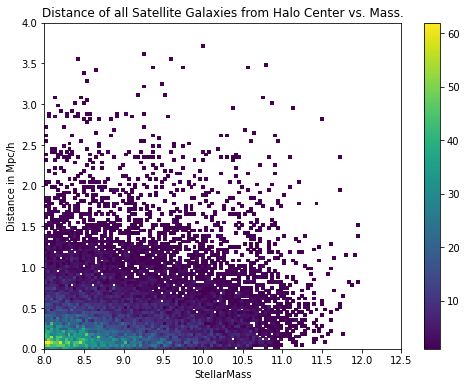

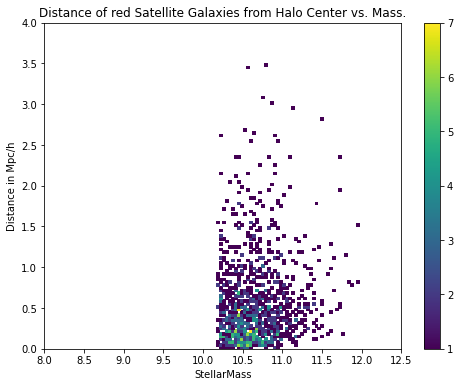

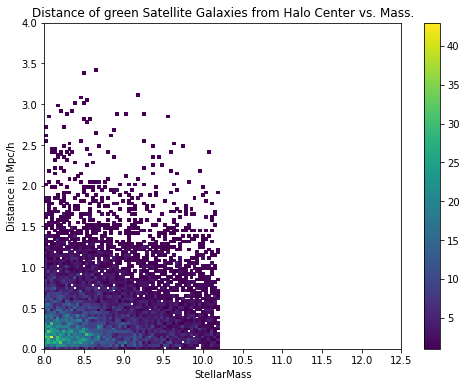

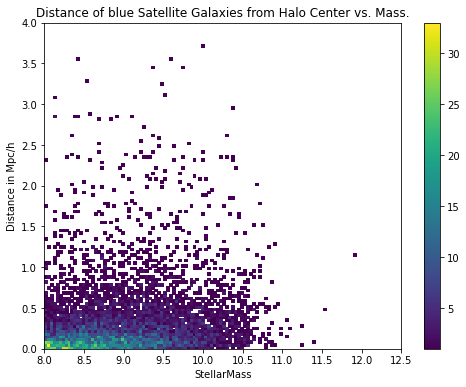

In [141]:

galaxy_dist_vs_mass(satellites, "Satellite Galaxies", "all", "StellarMass")
galaxy_dist_vs_mass(satellites_red, "Satellite Galaxies", "red", "StellarMass")
galaxy_dist_vs_mass(satellites_green, "Satellite Galaxies", "green", "StellarMass")
galaxy_dist_vs_mass(satellites_blue, "Satellite Galaxies", "blue", "StellarMass")

554.4514


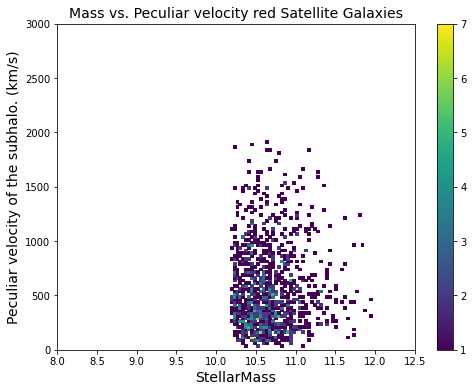

519.941


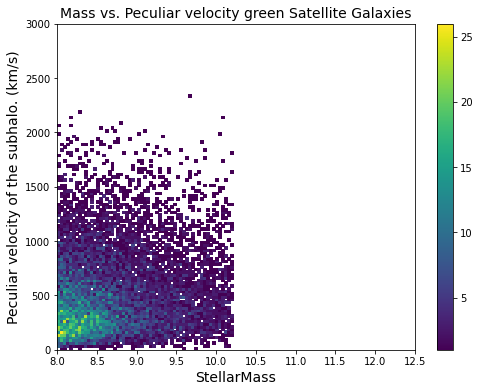

288.74588


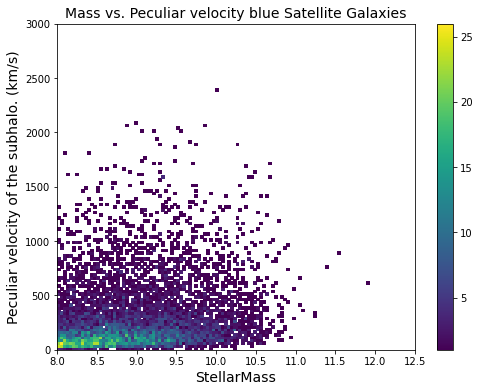

In [153]:
peculiar_velocity_vs_mass(satellites_red, "Satellite Galaxies", "red", "StellarMass")
peculiar_velocity_vs_mass(satellites_green, "Satellite Galaxies", "green", "StellarMass")
peculiar_velocity_vs_mass(satellites_blue, "Satellite Galaxies", "blue", "StellarMass")

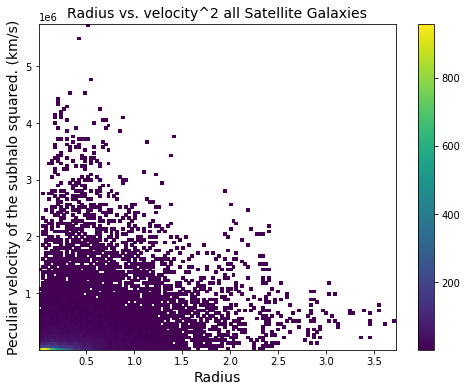

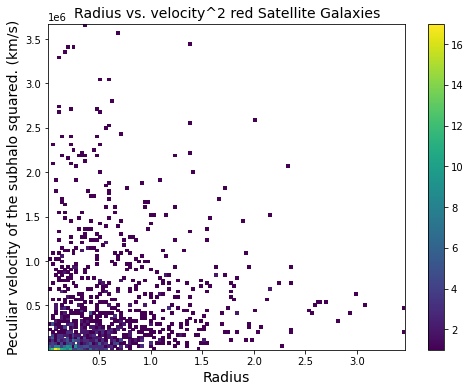

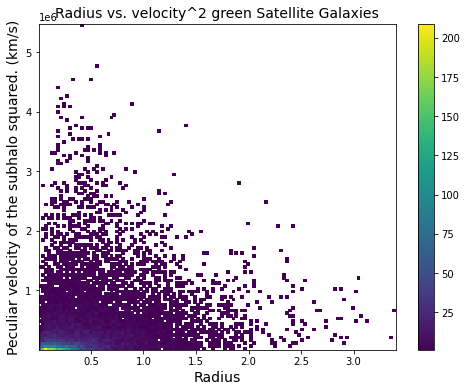

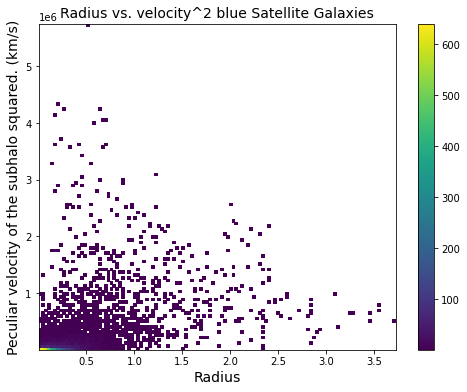

In [163]:
vsq_vs_r(satellites, "Satellite Galaxies", "all", "StellarMass")
vsq_vs_r(satellites_red, "Satellite Galaxies", "red", "StellarMass")
vsq_vs_r(satellites_green, "Satellite Galaxies", "green", "StellarMass")
vsq_vs_r(satellites_blue, "Satellite Galaxies", "blue", "StellarMass")